In [ ]:
!pip install -r "/content/drive/MyDrive/facedetection-main (1)/facedetection-main/requirements.txt"

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = "/content/drive/MyDrive/facedetection-main (1)/facedetection-main"

In [ ]:
def plot_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def insert_boundingboxes(boxes, image, method=None):
    frame = image.copy()
    if boxes is not None:
        for box in boxes:
            if method == 'CNN':
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            else:
                x, y, w, h = map(int, box)
                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

    return frame

In [ ]:
image = cv2.imread(PATH +'/images/onedi.jpg')

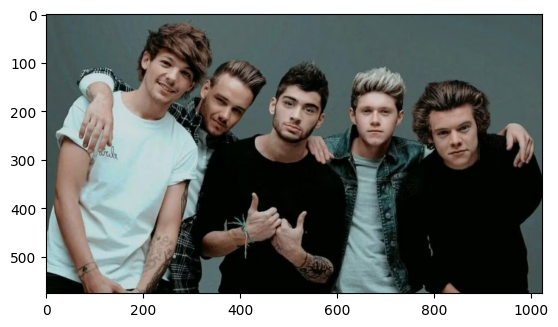

In [ ]:
plot_image(image)

## Viola-Jones (Haar Cascade)

### Etapas:

1. **Extrair Haar features**:
   - São aplicadas features simples (retângulos claros e escuros) em diferentes partes da imagem para identificar bordas e áreas contrastantes, como olhos e nariz.

2. **Imagem integral**:
   - A imagem é convertida em uma representação acumulativa para acelerar o cálculo das Haar features.

3. **AdaBoost**:
   - Um classificador AdaBoost seleciona as Haar features mais relevantes que podem identificar rostos.

4. **Cascata de classificadores**:
   - A imagem passa por uma série de classificadores simples. Áreas que não contêm um rosto são rapidamente descartadas nas primeiras camadas, e as regiões promissoras passam por classificadores mais complexos nas camadas finais.

### Resultado:
O algoritmo retorna as regiões da imagem que contêm rostos, com base em características específicas.

In [ ]:
def viola_jones_detection(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #transformando em grayscale
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') #moldar
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)) #escalonado a foto para adquirir varios tamanhos

    return faces #retorna a foto

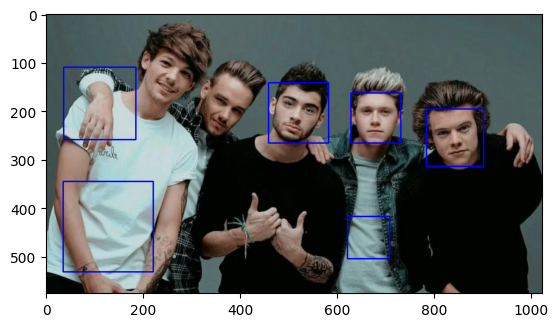

In [ ]:
boundingboxes = viola_jones_detection(image)
face_detected = insert_boundingboxes(boundingboxes, image)
plot_image(face_detected) #detecta a face, desenha o quadradoe printa

## 2. HOG + SVM

### Etapas:

1. **Calcular HOG (Histogram of Oriented Gradients)**:
   - A imagem é convertida em escala de cinza e dividida em pequenas células.
   - Para cada célula, os gradientes (mudanças na intensidade dos pixels) são calculados e agrupados em um histograma que representa as bordas e estruturas da face.

2. **Normalizar os histogramas**:
   - Para melhorar a robustez às variações de iluminação, os histogramas são normalizados.

3. **Treinar um SVM (Support Vector Machine)**:
   - O SVM é treinado para classificar os vetores de características HOG como "rosto" ou "não-rosto".

4. **Janela deslizante**:
   - Uma janela deslizante percorre a imagem em diferentes escalas para detectar rostos em várias posições e tamanhos.

### Resultado:
O SVM decide se a região contém ou não um rosto com base nas características HOG extraídas.

In [ ]:
import dlib
import cv2

In [ ]:
def hog_svm_detection(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detector = dlib.get_frontal_face_detector()
    faces = detector(gray, 1)
    boxes = [[face.left(), face.top(), face.width(), face.height()] for face in faces]

    return boxes

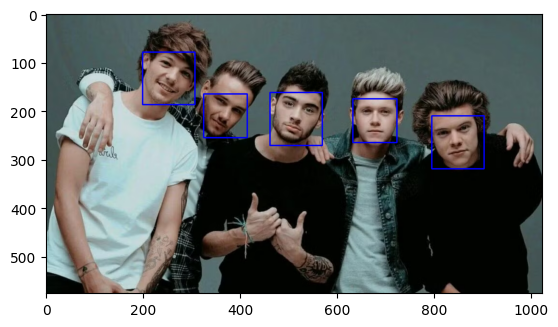

In [ ]:
boundingboxes = hog_svm_detection(image)
face_detected = insert_boundingboxes(boundingboxes, image)
plot_image(face_detected)

## 3. CNN (MTCNN)

### Etapas:

1. **P-Net (Proposal Network)**:
   - A imagem é processada por uma pequena CNN (P-Net) que faz uma estimativa inicial das regiões que podem conter rostos.
   - Ela gera propostas de janelas (bounding boxes) com alta probabilidade de conter um rosto.

2. **R-Net (Refinement Network)**:
   - As janelas propostas pelo P-Net são refinadas por outra CNN (R-Net), que ajusta as janelas e descarta falsas detecções.

3. **O-Net (Output Network)**:
   - As janelas refinadas são passadas por uma última CNN (O-Net), que gera a detecção final do rosto e pontos-chave faciais (como olhos, nariz e boca).

### Resultado:
MTCNN retorna as coordenadas das faces detectadas e os pontos-chave faciais.

In [ ]:
from facenet_pytorch import MTCNN

In [ ]:
def facenet_detection(frame):
    mtcnn = MTCNN(keep_all=True)
    boxes, _ = mtcnn.detect(frame)
    return boxes

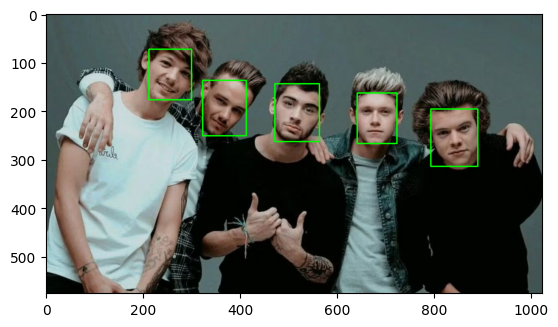

In [ ]:
boundingboxes = facenet_detection(image)
face_detected = insert_boundingboxes(boundingboxes, image, method='CNN')
plot_image(face_detected)

## 4. YOLO (You Only Look Once)

### Etapas:

1. **Divisão da imagem em uma grade**:
   - A imagem é dividida em uma grade (ex.: 7x7 células). Cada célula é responsável por prever se há um objeto (neste caso, uma face) em sua área.

2. **Rede Neural Convolucional (CNN)**:
   - Uma CNN processa toda a imagem de uma vez e, em uma única passagem, gera predições de bounding boxes (caixas delimitadoras) e a probabilidade de que um rosto esteja presente em cada uma dessas caixas.

3. **Non-Maximum Suppression (NMS)**:
   - Para remover sobreposições desnecessárias, a NMS filtra as caixas delimitadoras, deixando apenas as detecções com maior confiança.

### Resultado:
O YOLO retorna as coordenadas das faces detectadas em uma única execução da rede.

In [ ]:
from ultralytics import YOLO
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def yolo_bounding_boxes(image, boxes, confidences, class_ids):
    COCO_CLASSES = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light",
    "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed",
    "dining table", "toilet", "TV", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
    ]
    frame = image.copy()
    for box, confidence, class_id in zip(boxes, confidences, class_ids):
        # Filtrar apenas a classe 'person' (classe 0 no dataset COCO)
        # if int(class_id) == 0:  # Classe "0" corresponde a "person"
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(frame, f"Conf: {confidence:.2f} Class: {COCO_CLASSES[int(class_id)]}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    return frame

def yolo_v8_detection(image):
    model = YOLO(PATH +'/weights/yolov8n-face.pt')  # Usa o modelo genérico YOLOv8n

    results = model(image)
    frame = image.copy()
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Coordenadas das caixas
        confidences = result.boxes.conf.cpu().numpy()  # Confiança das detecções
        class_ids = result.boxes.cls.cpu().numpy()  # Classes detectadas

    return boxes, confidences, class_ids


0: 384x640 5 faces, 170.6ms
Speed: 5.5ms preprocess, 170.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


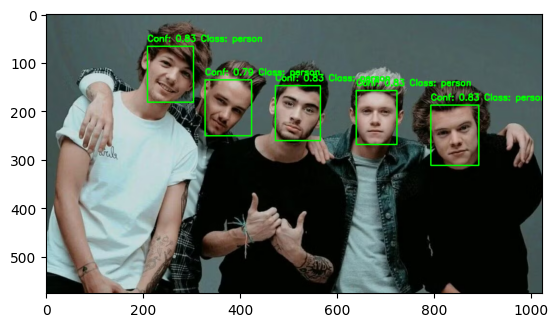

In [ ]:
boxes, confidences, class_ids = yolo_v8_detection(image)
face_detected = yolo_bounding_boxes(image, boxes, confidences, class_ids)
plot_image(face_detected)